## Iowa Housing Prices

Team Name: **Drop a Feature like its hot**

Team Members:
- Mohamad Sayed
- Andrew Hoffman
- Yasuhiro Shinohara

<a href="https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d">Xgboost</a>: Optimized Gradient Boosting Algorithm through parallel processing, tree-pruning, handling missing values, and regularization to avoid overfitting/bias*


#### Data Preparation

In [20]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn.model_selection as ms

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, make_scorer

from xgboost import XGBRegressor, XGBClassifier


In [21]:
# Loading train and test data sets
df_test = pd.read_csv("output_df_test.csv")
df_train = pd.read_csv("output_df_train.csv")

In [22]:
print(df_train.shape)
print(df_test.shape)

(1450, 47)
(1459, 46)


In [24]:
# Drop Id column
df_test_Id = pd.read_csv("output_df_test.csv").Id
df_train = df_train.drop('Id', axis = 1)
df_test = df_test.drop('Id', axis = 1)

In [25]:
df_train = pd.get_dummies(df_train, drop_first = True)
df_test = pd.get_dummies(df_test, drop_first = True)

In [26]:
X = df_train.loc[:, df_train.columns !='SalePrice']
Y = np.log(df_train[['SalePrice']])

In [27]:
# Split the train and test data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [28]:
#  Cross validation for 5 and 10 folds
cv5 = KFold(n_splits = 5, random_state = 1, shuffle = True)
cv10 = KFold(n_splits = 10, random_state = 1, shuffle = True)

#### Fitting Xgboost Model

In [29]:
xgb = XGBRegressor()
xgb.set_params(random_state = 1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [30]:
#set up xgb with random parameter
xgb = XGBRegressor()
xgb.set_params(random_state=123)
xgb.fit(X, Y)

[18:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [31]:
# R-squared for train and test sets for xgboost model

print("R^2 for train set is: %.6f" % xgb.score(X_train, Y_train))
print("R^2 for train set is: %.6f" % xgb.score(X_test, Y_test))

R^2 for train set is: 0.942208
R^2 for train set is: 0.906992


##### Errors for Xgboost Model

In [32]:
# Prediction Errors

xgb_prediction = xgb.predict(X_test)

mse = mean_squared_error(Y_test, xgb_prediction)                     # Mean Squared Error
abs_error = abs(np.expm1(xgb_prediction) - np.expm1(Y_test).values)  # Absolute errors
mape = (abs_error / np.expm1(Y_test).values) * 100                   # Mean Absolute Percentage Error - MAPE

print('Mean Squared Error: ', round(mse, 6))   #  MSE
print('Root Mean Squared Error: ', round(np.sqrt(mse), 5))   #  RMSE
print('Mean Absolute Error: ', round(np.mean(abs_error), 3))   #  MAE
print('Mean Absolute Percent Error: ', round(np.mean(mape), 3))   #  MAPE


Mean Squared Error:  0.013988
Root Mean Squared Error:  0.11827
Mean Absolute Error:  75774.172
Mean Absolute Percent Error:  46.862


MSE of 0.013988 & RMSE of 0.11827

#### Parameter Tuning

In [35]:
xgb_param_grid = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
                           'n_estimators' : range(500, 1000, 50),
                            'max_depth' : range(2,6),
                            'min_child_weight' : range(4,8)
                           }

# random_search_xgb_10 = RandomizedSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
#                                      cv= cv10, n_jobs=-1, return_train_score = True)

random_search_xgb_5 = RandomizedSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= cv5, n_jobs=-1, return_train_score = True)

# %time random_search_xgb_10.fit(X, Y)
%time random_search_xgb_5.fit(X, Y)

[18:39:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6.2 s, sys: 237 ms, total: 6.43 s
Wall time: 5min 30s
[18:41:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 4.13 s, sys: 60.4 ms, total: 4.19 s
Wall time: 2min 31s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'n_estimators': range(500, 1000, 50), 'max_depth': range(2, 6), 'min_child_weight': range(4, 8)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verb

In [36]:
# Best parameters from Random Search
# xgb_random10 = random_search_xgb_10.best_estimator_
xgb_random5 = random_search_xgb_5.best_estimator_

# Train and Test scores

# print("R^2 for train set after 10-fold cv is: %.6f" % xgb_random10.score(X_train, Y_train))  # 10 fold
# print("R^2 for train set after 5-fold cv is: %.6f" % xgb_random10.score(X_test, Y_test))    # 10 fold

print("R^2 for train set after 5-fold cv is: %.6f" % xgb_random5.score(X_train, Y_train))  # 5 fold
print("R^2 for train set after 5-fold cv is: %.6f" % xgb_random5.score(X_test, Y_test))     # 5 fold

R^2 for train set after 5-fold cv is: 0.952042
R^2 for train set after 5-fold cv is: 0.918847


In [ ]:
# Since 10-fold cross validation doesn't improve the model R^2, then will stick to 5-folds

##### Errors for Tuned Hyperparameters - Xgboost

In [37]:
random_search_xgb_5

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'n_estimators': range(500, 1000, 50), 'max_depth': range(2, 6), 'min_child_weight': range(4, 8)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verb

In [38]:
xgb_prediction_random = xgb_random5.predict(X_test)

mse = mean_squared_error(Y_test, xgb_prediction_random)                     # Mean Squared Error
abs_error = abs(np.expm1(xgb_prediction_random) - np.expm1(Y_test).values)  # Absolute errors
mape = (abs_error / np.expm1(Y_test).values) * 100                   # Mean Absolute Percentage Error - MAPE


print('Mean Squared Error: ', round(mse, 6))   #  MSE
print('Root Mean Squared Error: ', round(np.sqrt(mse), 5))   #  RMSE
print('Mean Absolute Error: ', round(np.mean(abs_error), 3))   #  MAE
print('Mean Absolute Percent Error: ', round(np.mean(mape), 3))   #  MAPE

Mean Squared Error:  0.012205
Root Mean Squared Error:  0.11048
Mean Absolute Error:  76039.327
Mean Absolute Percent Error:  47.092


MSE of 0.012205 & RMSE of 0.11048

##### Plotting of Predictions

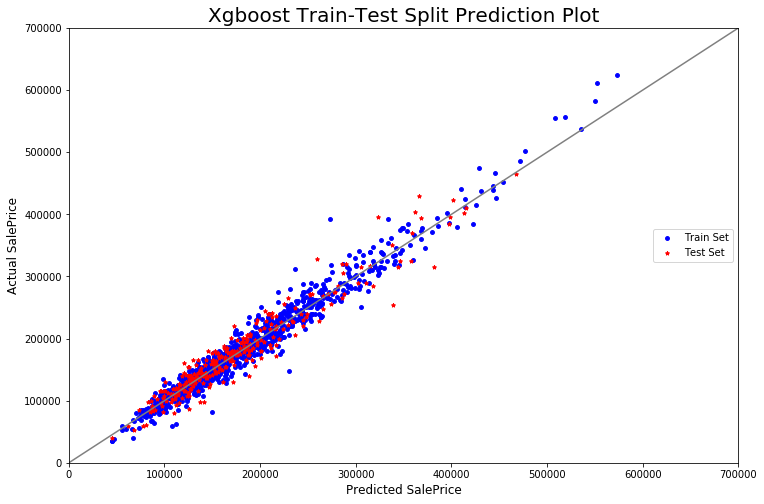

In [105]:
y_train_xgboost = xgb_random5.predict(X_train)
y_test_xgboost = xgb_random5.predict(X_test)

plt.figure(figsize=(12,8))

plt.scatter(np.expm1(y_train_xgboost), np.expm1(Y_train), c='Blue', s=15, marker="o", label = "Train Set")
plt.scatter(np.expm1(y_test_xgboost), np.expm1(Y_test), c='Red', s=15, marker='*', label = "Test Set")

plt.title("Xgboost Train-Test Split Prediction Plot", fontsize = 20)

plt.xlabel("Predicted SalePrice", fontsize = 12)
plt.ylabel("Actual SalePrice", fontsize = 12)

plt.xlim(0, 700000)
plt.ylim(0, 700000)
plt.legend(loc = "center right")
plt.plot([0, 700000], [0, 700000], c = "grey")
plt.show()

##### Predict Final SalePrice using Xgboost

In [63]:
# using best xgboost model with random search of 5-fold cv to predict the SalePrice for the test set
xgb_ytest = xgb_random5.predict(df_test)


In [65]:
np.expm1(xgb_ytest).shape

(1459,)

In [67]:
df_test_Id = pd.read_csv("output_df_test.csv").Id

In [69]:
xgb_best_prediction = pd.DataFrame(data = (np.expm1(xgb_ytest)), columns = ['SalePrice'])
xgb_predicted_SalePrice = pd.concat([df_test_Id , xgb_best_prediction], axis = 1)
xgb_predicted_SalePrice.tail(5)

,Id,SalePrice
1454,2915,72762.320312
1455,2916,80449.148438
1456,2917,162143.390625
1457,2918,119325.429688
1458,2919,229480.859375


##### Final SalePrice Prediction for Kaggle Score

In [70]:
xgb_predicted_SalePrice.to_csv('xgb_SalePrice.csv', index = False)